# Term Deposit Marketing Project

## Data Description:

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

### Attributes:

- age : age of customer (numeric)

- job : type of job (categorical)

-  marital : marital status (categorical)

- education (categorical)

- default: has credit in default? (binary)

- balance: average yearly balance, in euros (numeric)

- housing: has a housing loan? (binary)

- loan: has personal loan? (binary)

- contact: contact communication type (categorical)

- day: last contact day of the month (numeric)

- month: last contact month of year (categorical)

- duration: last contact duration, in seconds (numeric)

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

### Output (desired target):

- y - has the client subscribed to a term deposit? (binary)

### Import Libraries

In [58]:
# random
import random

# cell output clear tool
from IPython.display import clear_output

# data
import pandas as pd
import numpy as np

# visualisations
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# basic models
from lazypredict.Supervised import LazyClassifier

# shap
import shap

#chisquare
from scipy.stats import chi2_contingency

# sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.inspection import permutation_importance

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestCentroid

# imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### Load Data and Data Preprocessing

In [3]:
# load dataset
data = pd.read_csv("Data/term-deposit-marketing-2020.csv")
original_data = data.copy()
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
# get info about the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


There are no missing or null data to replace in the dataset

In [5]:
# see if there are duplicates rows in the data
sum(data.duplicated())

0

There are no duplicated rows to drop

In [6]:
# Check for unique labels in each CATEOGRICAL column only
for col in data.columns:
    if(data[col].dtype.name != 'object'): continue
    print(f'{col}: {len(data[col].unique())}\n')

    # print the variables with >2 unique variables to use them later with OrdinalNumberEncoding
    if(len(data[col].unique()) > 2):
        print(f'{data[col].unique()}\n')

job: 12

['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

marital: 3

['married' 'single' 'divorced']

education: 4

['tertiary' 'secondary' 'unknown' 'primary']

default: 2

housing: 2

loan: 2

contact: 3

['unknown' 'cellular' 'telephone']

month: 11

['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']

y: 2



In [7]:
# we will replace the categories with 2 unique values with 1 or 0 using OneHotEncoding
y_converted_variable = pd.get_dummies(data['y'], drop_first=True, dtype='int64') # yes = 1, no = 0
loan_converted_variable = pd.get_dummies(data['loan'], drop_first=True, dtype='int64') # yes = 1, no = 0
housing_converted_variable = pd.get_dummies(data['housing'], drop_first=True, dtype='int64') # yes = 1, no = 0
default_converted_variable = pd.get_dummies(data['default'], drop_first=True, dtype='int64') # yes = 1, no = 0

# function to help us with replacing the new onehotencoding columns
def replace_coverted_variable(data, df, variable):
    data = pd.concat([data, df], axis=1)
    data.drop(variable, axis=1, inplace=True)
    data.rename(columns={'yes': variable}, inplace=True)
    return(data)

data = replace_coverted_variable(data, y_converted_variable, 'y')
data = replace_coverted_variable(data, loan_converted_variable, 'loan')
data = replace_coverted_variable(data, housing_converted_variable, 'housing')
data = replace_coverted_variable(data, default_converted_variable, 'default')
data.head()


,age,job,marital,education,balance,contact,day,month,duration,campaign,y,loan,housing,default
0,58,management,married,tertiary,2143,unknown,5,may,261,1,0,0,1,0
1,44,technician,single,secondary,29,unknown,5,may,151,1,0,0,1,0
2,33,entrepreneur,married,secondary,2,unknown,5,may,76,1,0,1,1,0
3,47,blue-collar,married,unknown,1506,unknown,5,may,92,1,0,0,1,0
4,33,unknown,single,unknown,1,unknown,5,may,198,1,0,0,0,0


In [8]:
# we will replace the categories with more than 2 unique values with OrdinalNumberEncoding
# we create dictionaries for each variable and keep it for future reference
mapping_dictionary_value_job = {'management': 0, 'technician': 1, 'entrepreneur': 2, 'blue-collar': 3, 'unknown': 4,
'retired': 5, 'admin': 6, 'services': 7, 'self-employed': 8, 'unemployed': 9, 'housemaid': 10,'student': 11}

mapping_dictionary_value_month = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'oct': 10, 'nov': 11, 'dec': 12}

mapping_dictionary_value_marital = {'married': 2, 'single': 1, 'divorced': 0}

mapping_dictionary_value_education = {'tertiary': 0, 'secondary': 1, 'unknown': 2, 'primary': 3}

mapping_dictionary_value_contact = {'unknown': 0, 'cellular': 1, 'telephone': 2}

In [9]:
# replacing the categorical values with their mapping
data['job'] = data.job.map(mapping_dictionary_value_job)
data['month'] = data.month.map(mapping_dictionary_value_month)
data['marital'] = data.marital.map(mapping_dictionary_value_marital)
data['education'] = data.education.map(mapping_dictionary_value_education)
data['contact'] = data.contact.map(mapping_dictionary_value_contact)
data

,age,job,marital,education,balance,contact,day,month,duration,campaign,y,loan,housing,default
0,58,0,2,0,2143,0,5,5,261,1,0,0,1,0
1,44,1,1,1,29,0,5,5,151,1,0,0,1,0
2,33,2,2,1,2,0,5,5,76,1,0,1,1,0
3,47,3,2,2,1506,0,5,5,92,1,0,0,1,0
4,33,4,1,2,1,0,5,5,198,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,1,2,0,395,1,3,6,107,1,0,0,0,0
39996,30,0,1,0,3340,1,3,6,238,3,1,0,0,0
39997,54,6,0,1,200,1,3,6,170,1,1,0,0,0
39998,34,0,2,0,1047,1,3,6,342,1,0,0,0,0


In [10]:
# get info about the data after replacing categorical variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        40000 non-null  int64
 1   job        40000 non-null  int64
 2   marital    40000 non-null  int64
 3   education  40000 non-null  int64
 4   balance    40000 non-null  int64
 5   contact    40000 non-null  int64
 6   day        40000 non-null  int64
 7   month      40000 non-null  int64
 8   duration   40000 non-null  int64
 9   campaign   40000 non-null  int64
 10  y          40000 non-null  int64
 11  loan       40000 non-null  int64
 12  housing    40000 non-null  int64
 13  default    40000 non-null  int64
dtypes: int64(14)
memory usage: 4.3 MB


In [11]:
# move y column in the start of the data table
col = data.pop("y")
data.insert(0, col.name, col)

In [12]:
# Get statistics about the data
data.describe()

,y,age,job,marital,education,balance,contact,day,month,duration,campaign,loan,housing,default
count,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00
mean,0.07,40.54,3.45,1.49,1.07,1274.28,0.74,16.02,6.01,254.82,2.88,0.17,0.60,0.02
std,0.26,9.64,3.02,0.70,0.97,2903.77,0.56,8.28,2.30,259.37,3.24,0.38,0.49,0.14
min,0.00,19.00,0.00,0.00,0.00,-8019.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00
25%,0.00,33.00,1.00,1.00,0.00,54.00,0.00,8.00,5.00,100.00,1.00,0.00,0.00,0.00
50%,0.00,39.00,3.00,2.00,1.00,407.00,1.00,17.00,6.00,175.00,2.00,0.00,1.00,0.00
75%,0.00,48.00,6.00,2.00,1.00,1319.00,1.00,21.00,7.00,313.00,3.00,0.00,1.00,0.00
max,1.00,95.00,11.00,2.00,3.00,102127.00,2.00,31.00,12.00,4918.00,63.00,1.00,1.00,1.00


### Visualization of data and each feature

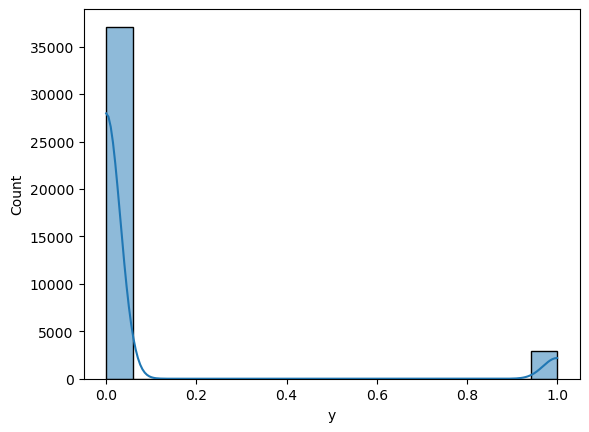

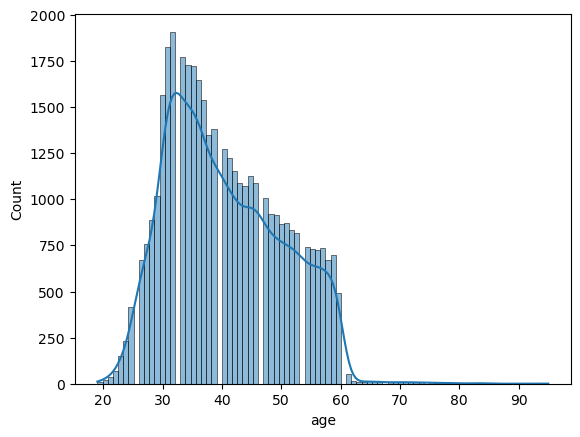

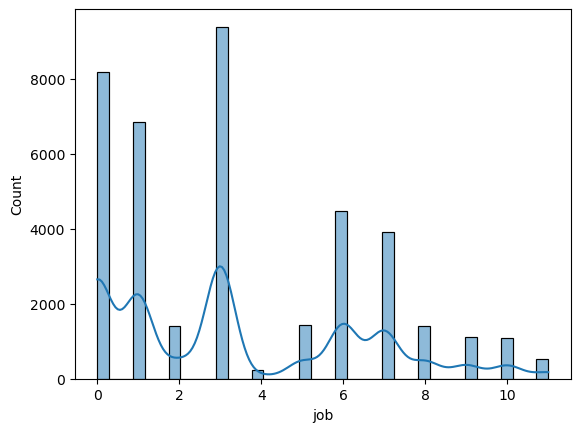

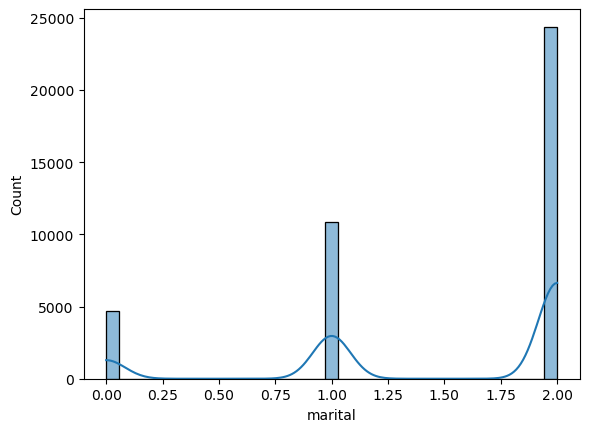

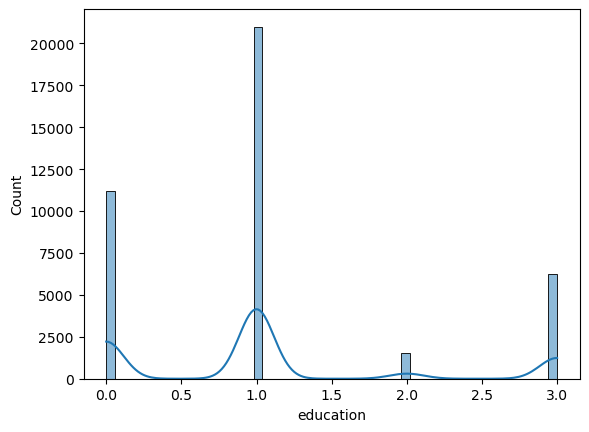

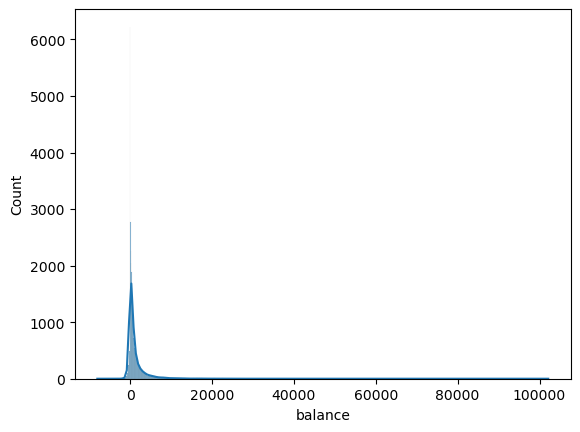

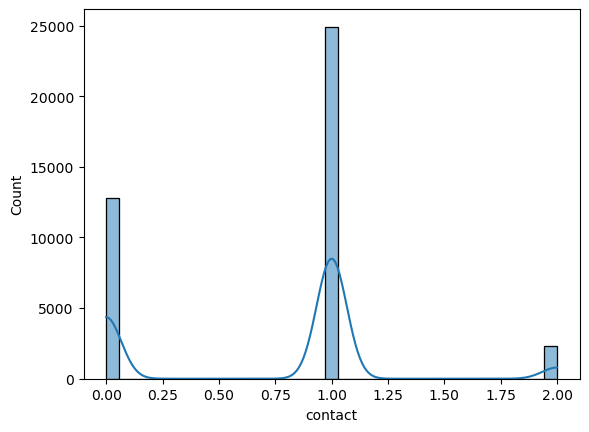

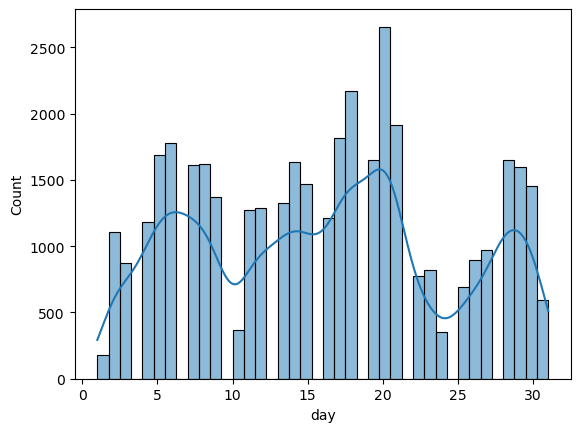

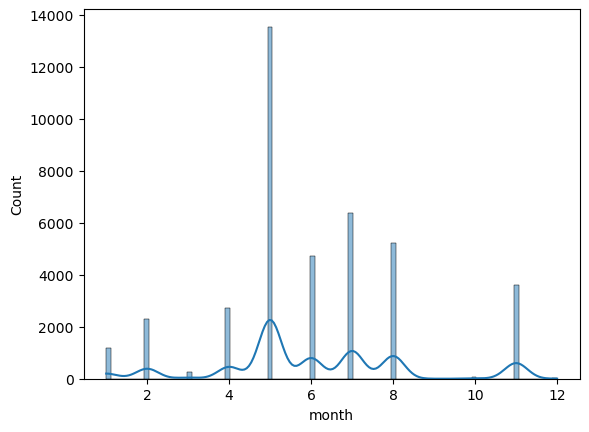

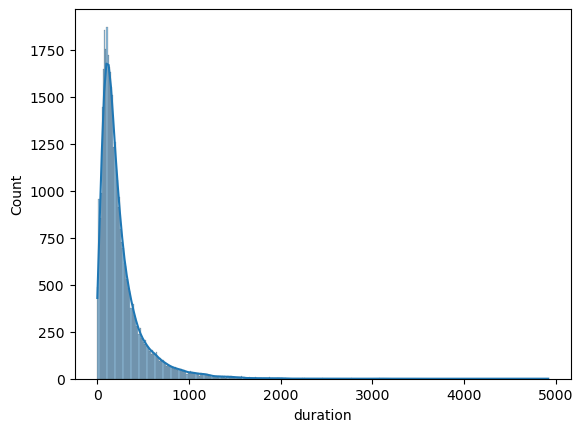

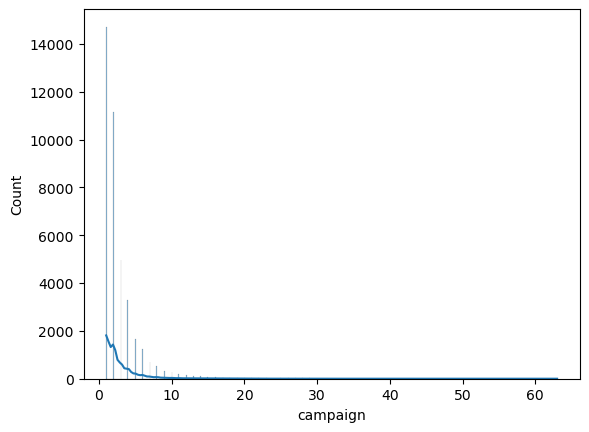

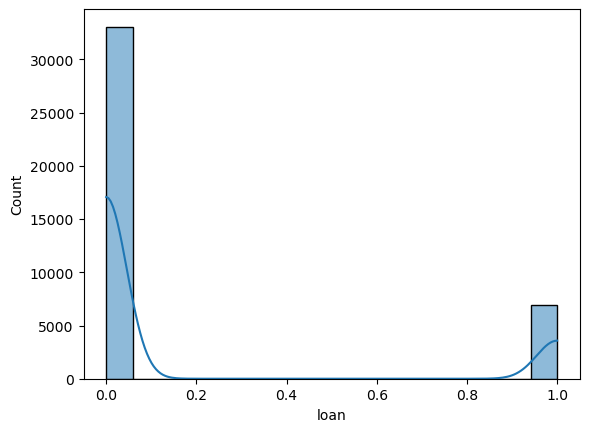

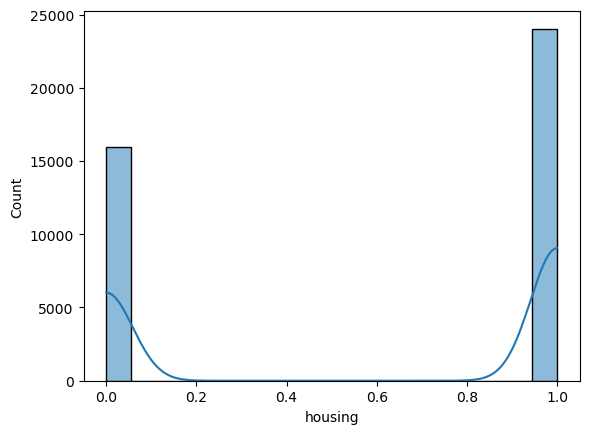

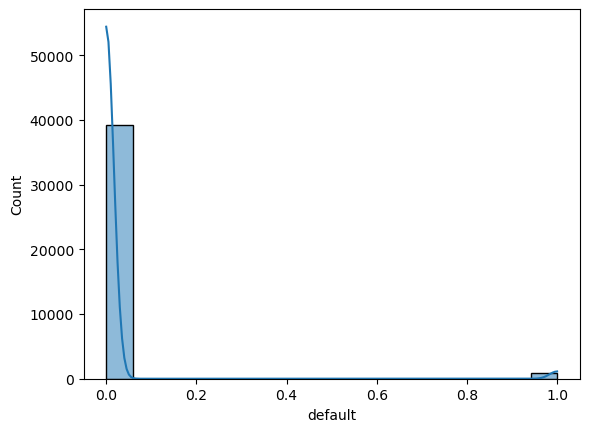

In [13]:
# distributions
for col in data.columns[:]:
  plt.figure()
  sns.histplot(data=data, x=col, kde=True)

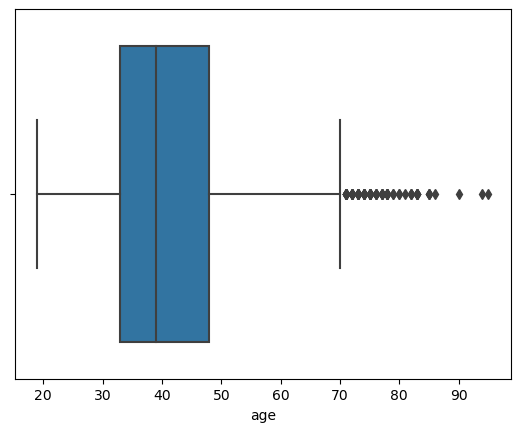

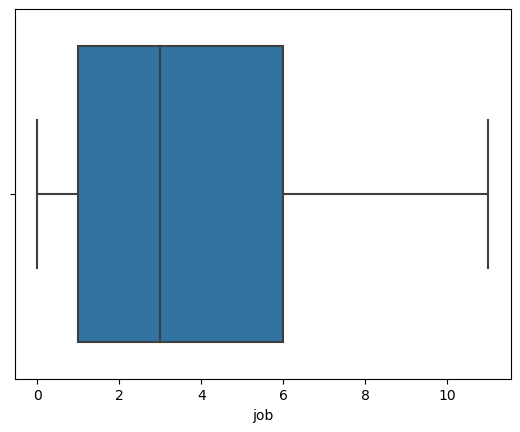

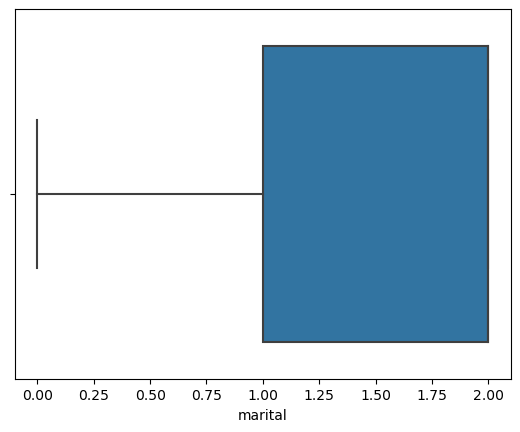

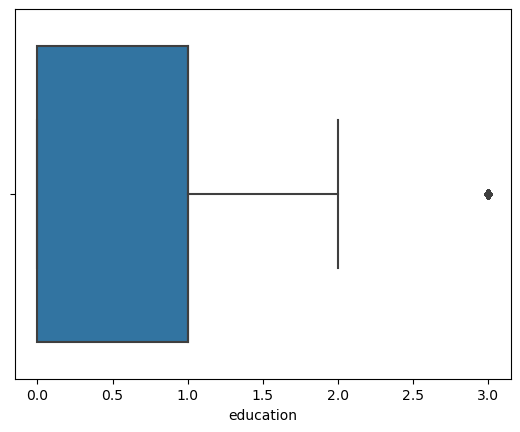

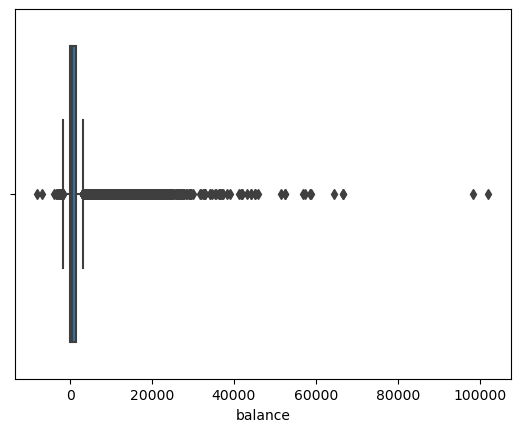

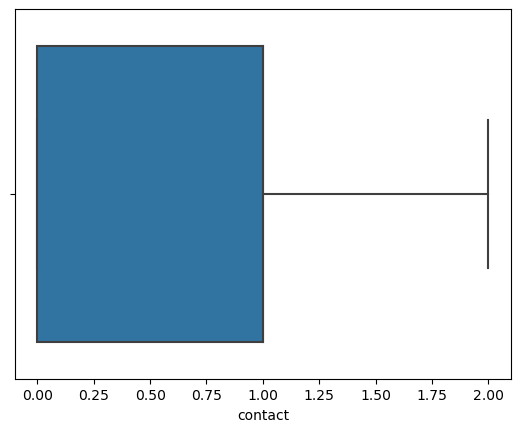

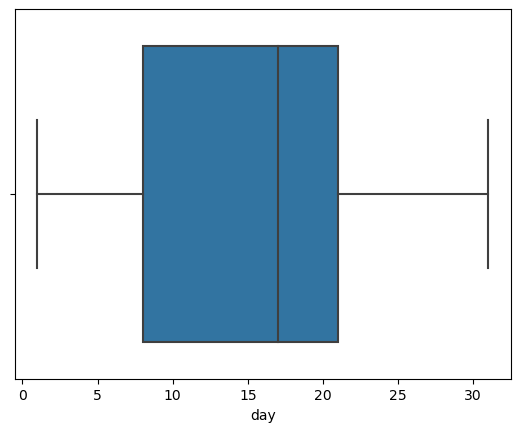

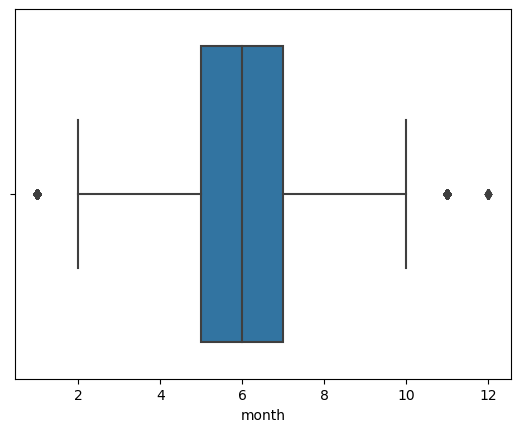

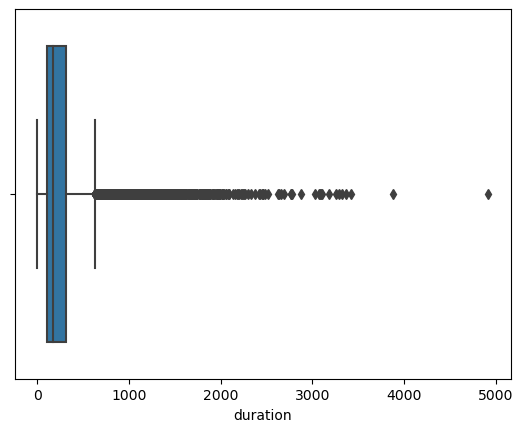

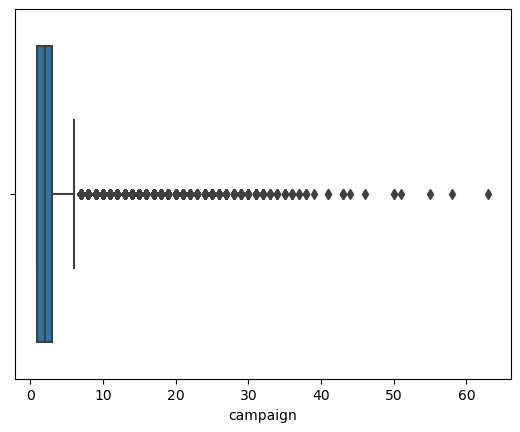

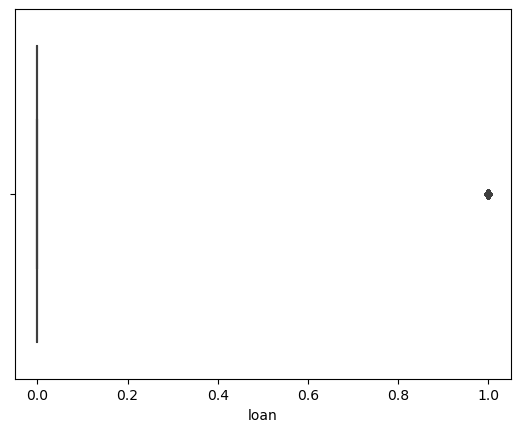

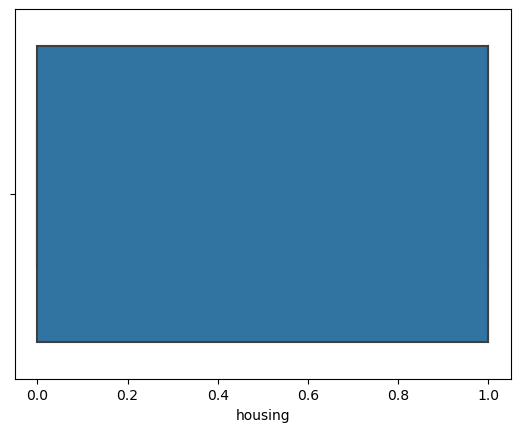

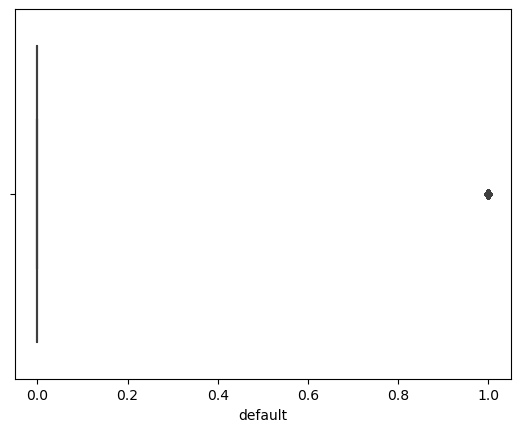

In [14]:
# boxplot to see for outliers
for col in data.columns[1:]:
  plt.figure()
  sns.boxplot(data=data, x=col)

### Hypothesis Testing (not complete yet)

In [52]:
# Resultant Dataframe will be a dataframe where the column names and Index will be the same
# This is a matrix similar to correlation matrix which we get after df.corr()
# Initialize the values in this matrix with 0
resultant = pd.DataFrame(data=[(0 for i in range(len(data.columns))) for i in range(len(data.columns))], 
                         columns=list(data.columns))
resultant.set_index(pd.Index(list(data.columns)), inplace = True)

# Finding p_value for all columns and putting them in the resultant matrix
for i in list(data.columns):
    for j in list(data.columns):
        if i != j:
            chi2_pval = chi2_contingency(pd.crosstab(data[i], data[j]))[1]
            resultant.loc[i,j] = chi2_pval

print(resultant)

             y  age  job  marital  education  balance  contact  day  month  \
y         0.00 0.00 0.00     0.00       0.00     0.00     0.00 0.00   0.00   
age       0.00 0.00 0.00     0.00       0.00     0.00     0.00 0.00   0.00   
job       0.00 0.00 0.00     0.00       0.00     0.00     0.00 0.00   0.00   
marital   0.00 0.00 0.00     0.00       0.00     0.00     0.00 0.00   0.00   
education 0.00 0.00 0.00     0.00       0.00     0.00     0.00 0.00   0.00   
balance   0.00 0.00 0.00     0.00       0.00     0.00     0.00 1.00   0.00   
contact   0.00 0.00 0.00     0.00       0.00     0.00     0.00 0.00   0.00   
day       0.00 0.00 0.00     0.00       0.00     1.00     0.00 0.00   0.00   
month     0.00 0.00 0.00     0.00       0.00     0.00     0.00 0.00   0.00   
duration  0.00 1.00 0.00     0.00       0.08     0.00     0.00 0.00   0.00   
campaign  0.00 0.01 0.00     0.00       0.00     1.00     0.00 0.00   0.00   
loan      0.00 0.00 0.00     0.00       0.00     0.00     0.00 0

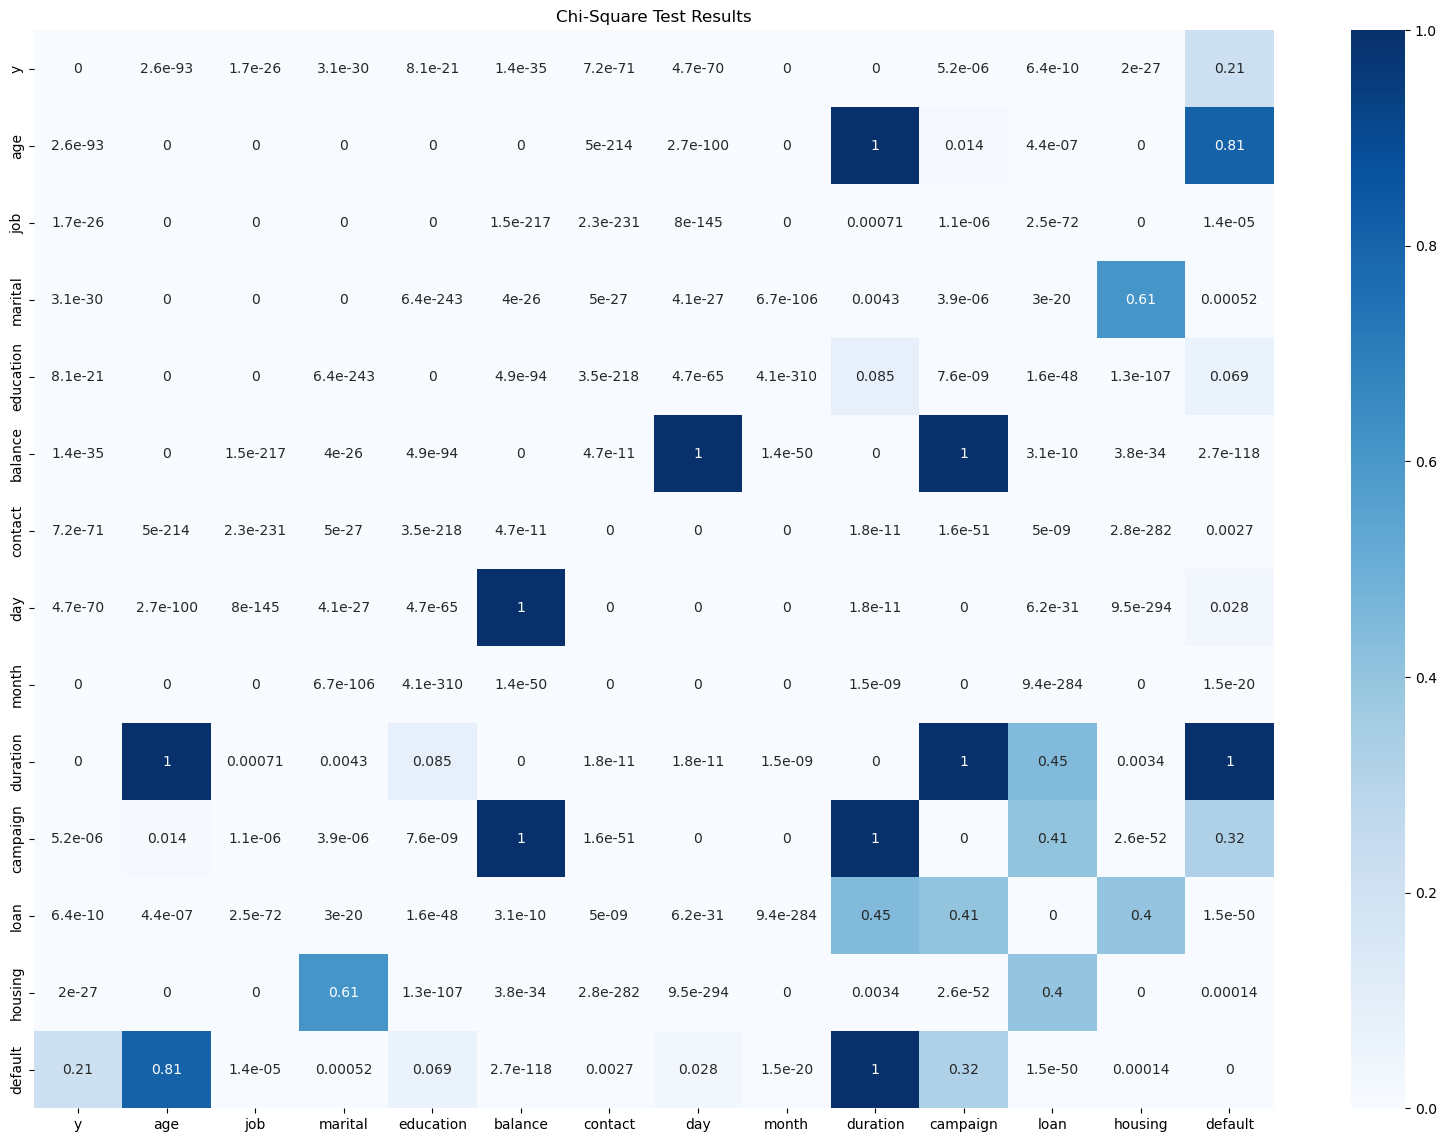

In [57]:
# Plotting a heatmap
fig = plt.figure(figsize=(20,14))
sns.heatmap(resultant, annot=True, cmap='Blues')
plt.title('Chi-Square Test Results')
plt.show()

### Checking for imbalanced dataset

In [15]:
df_percentage = pd.DataFrame(data['y'].value_counts())
df_percentage['Percentage (%)'] = (df_percentage['y']/df_percentage['y'].sum())*100
df_percentage

,y,Percentage (%)
0,37104,92.76
1,2896,7.24


* We see that the dataset is not balanced. 
* We will use a combination of SMOTE with random undersampling to create a balanced dataset to use in the model.